# Python for Scientists
## Day 2 Notebook
This notebook was developed for the NASA Goddard Space Flight Center and CRESST II's post-baccalaureate program by [Joe P. Renaud](https://www.josephrenaud.com) in Spring, 2024.

**Prerequisites for running this notebook**
_Forget what you called your conda environment? Try `conda env list`_
* All the pre-reqs for Day 1 plus...
* Open val1 terminal and install packages using conda (or `pip install`):
    * `conda install astropy pytest numba`
    * `pip install astroquery chardet` # This one has to be installed with pip

## Astroquery Data Download
Astroquery has a ton of different databases that you can download from.
Read more here: https://astroquery.readthedocs.io/en/latest/

### Chandra Data

In [1]:
# Plot all of the dates and exposure times that Chandra observed M31, M49, M51, M58
from datetime import datetime

import numpy as np
from astroquery.esasky import ESASky

object_colors = {
    'M31': 'red',
    'M49': 'orange',
    'M51': 'green',
    'M58': 'blue',
}

galaxy_results = dict()
for obj_name, obj_color in object_colors.items():
    all_data = ESASky.query_object_maps(position=obj_name, missions="CHANDRA")[0]

    # The names of these columns are (hopefully) well documented on the respective catalogue's website
    exposure_times = all_data['t_exptime']
    exposure_times /= (60 * 60)  # Convert exposure times to hours

    observation_dates = all_data['obs_release_date']
    # Use a vectorized form of the datatime to convert the iso date strings to datatime objects
    observation_dates = np.vectorize(datetime.fromisoformat)(observation_dates)

    galaxy_results[obj_name] = (obj_color, exposure_times, observation_dates)


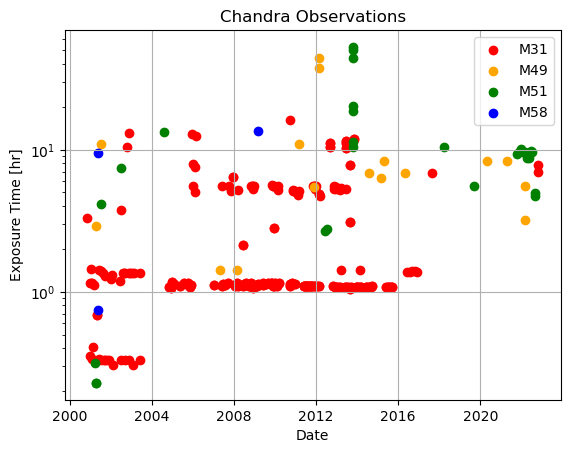

In [4]:
# It is always a good idea to separate data processing and plotting. Otherwise you will have to redo all of your 
# data processing (which could be computationally expensive) every time you just need to tweak a plot element.

import matplotlib.pyplot as plt
fig, ax = plt.subplots()

for obj_name, (obj_color, exposure_times, observation_dates) in galaxy_results.items():
    ax.scatter(observation_dates, exposure_times, c=obj_color, label=obj_name)

ax.set(title="Chandra Observations", xlabel='Date', ylabel='Exposure Time [hr]', yscale='log')
ax.grid()
ax.legend(loc='best')
plt.show()

### Exoplanet Archive

In [ ]:
from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive

discovery_methods = {
    'Microlensing': ("cyan", None),
    'Radial Velocity': ("red", None),
    'Imaging': ("blue", None),
    'Eclipse Timing Variations': ('orange', 'TTV'),
    'Transit': ("green", None),
    'Transit Timing Variations': ('orange', 'TTV'),
    'Astrometry': ('purple', None),
}

exoplanet_results = dict()

for discovery_method, (color, save_name) in discovery_methods.items():
    # This archive uses a SQL-like search feature
    data = \
        NasaExoplanetArchive.query_criteria(
            table='ps',
            select='pl_name, pl_orbsmax, pl_masse',
            where=f"default_flag like '1' AND discoverymethod like '{discovery_method}'")
    
    if save_name is None:
        save_name = discovery_method

    exoplanet_results[save_name] = {
        'color': color,
        'semi_major_axis': data['pl_orbsmax'],
        'earth_mass': data['pl_masse']
        }

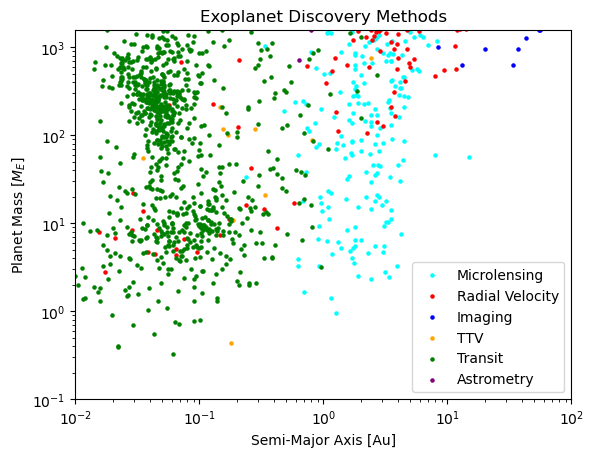

In [ ]:
fig, ax = plt.subplots()

for discovery_method, exoplanet_data in exoplanet_results.items():
    ax.scatter(exoplanet_data['semi_major_axis'], exoplanet_data['earth_mass'],
            c=exoplanet_data['color'], s=5, label=discovery_method)

ax.set(xlabel='Semi-Major Axis [Au]', ylabel='Planet Mass [$M_{E}$]', xscale='log', yscale='log',
       title="Exoplanet Discovery Methods")

# Assume anything above ~ 50x Jupiter mass (1600 Earth mass) is getting close to brown dwarf territory.
ax.set(ylim=(1e-1, 1600), xlim=(1e-2, 1e2))

ax.legend(loc='best')
plt.show()

## Debugging Python
Debugging is always _fun_. The best way to debug is to not debug at all. You would be surprised how much you can avoid by having proper unit tests (see later section). 

However, no matter how much you try to avoid it, you will have to debug eventually. 

In [ ]:
# `print` debugging - Simply add print statements everywhere.

# Suppose there is a function that is not giving me the correct result

def broken_func(scale, b):

    if scale < 0 and b > 0:
        return b
    elif scale > 0 and b > 0:
        return b - scale
    else:
        return scale

print(broken_func(0, 3))  # I am expecting to get back 3 - 0 == 3; but I get back 0.


0


In [ ]:
# I can add print commands everywhere to find the problem
def broken_func2(scale, b):
    
    print(f'Func Start scale={scale}, b={b}')
    if scale < 0 and b > 0:
        print('Check 1')
        return b
    elif scale > 0 and b > 0:
        print('Check 2')
        return b - scale
    else:
        print('Check 3')
        return scale

print(broken_func2(0, 3))
# Now I can see that the code never reaches check 2. I see the bug is caused by "a > 0" should be "a >= 0"

Func Start a=0, b=3
Check 3
0


In [ ]:
# We can also use Python's built in debugger "pdb.set_trace()" to create an interactive terminal for us to explore variables
# Note that newer versions of python allow you to replace "pdb.set_trace()" with simply "breakpoint", but this currently does not work in jupyter notebooks.

def broken_func3(scale, b):
    
    print(f'Func Start scale={scale}, b={b}')

    import pdb
    pdb.set_trace()

    if scale < 0 and b > 0:
        print('Check 1')
        return b
    elif scale > 0 and b > 0:
        print('Check 2')
        return b - scale
    else:
        print('Check 3')
        return scale

print(broken_func3(0, 3))

Func Start a=0, b=3
> c:\users\jrenaud\appdata\local\temp\1\ipykernel_18120\2001527067.py(11)broken_func3()

a = 0
b = 3
a = 0
b = 3
3


## Documentation and Unit Testing
### Documentation

*3 Rules of Documenting Code*
1) Use useful function and variable names so you don't have to document.


In [ ]:
def my_func(x, m, b):
    return m * x + b

x, m, b = 7.0, 0.2, 10.
y = my_func(x, m, b)
print("y is", y)

def calculate_height(time, slope, intercept):
    return slope * time + intercept

time, slope, intercept = 7.0, 0.2, 10.
height = calculate_height(time, slope, intercept)
print("Height is", height)

y is 11.4
Height is 11.4


1b) Where performance is not a major concern, consider using astropy units to further define what you are calculating

In [ ]:
import astropy.units as u

def calculate_height(time, slope, intercept):
    return slope * time + intercept

time = 7.0 * u.s
slope = 0.2 * u.m / u.s
intercept = 10. * u.m

height = calculate_height(time, slope, intercept)
print("Height is", height)
print(type(height))
print(height.unit)

Height is 11.4 m
<class 'astropy.units.quantity.Quantity'>
m


2) Use in-line comments to explain coding or method nuances that someone using your code may not care about but anyone
editing your code (including future you!) will.

In [ ]:
import astropy.units as u

def calculate_height(time, slope, intercept):
    # Make sure height is positive. Negative height will cause a crash later in the program
    height = slope * time + intercept
    if height < 0:
        height = 0
        # TODO: Should we throw a warning or an error here to let the user know that a bad value was calculated?
    return height

time = 7.0 * u.s
slope = 0.2 * u.m / u.s
intercept = 10. * u.m

height = calculate_height(time, slope, intercept)
print("Height is", height)

3) Add "docstrings" so that _both users and developers_ of your code know what a function or class does. Its limitations.
Its assumptions. etc.

In [ ]:
import astropy.units as u

def calculate_height(time, velocity, initial_height):
    """Calculates the height of a baseball.

    Assumptions:
    - Does not take into account air resistance or other frictions.
    - Does not allow the baseball to end below ground (height < 0).

    Parameters
    ----------
    time : float, [s]
        Time at which to calculate the height of the baseball.
    velocity : float, [m s-1]
        Velocity of the baseball
    initial_height : float, [m]
        Initial height of the baseball.

    Returns
    -------
    height : float, [m]
        Height of the baseball at provided `time`.
    
    Raises
    ------
    ValueError
        If the calculated height is less than 0 a value error will be raised.
    """
    # Make sure height is positive. Negative height will cause a crash later in the program
    height = velocity * time + initial_height
    if height < 0:
        raise ValueError("Height found to be less than zero which is not permitted.")
    return height

time = 7.0 * u.s
velocity = 0.2 * u.m / u.s
initial_height = 10. * u.m

height = calculate_height(time, velocity, initial_height)
print("Height is", height)

Height is 11.4 m


### Unit Testing
Tests must be in a folder that starts with "test_*" and in files that also start with "test_*"

- Open a terminal and navigate to the main directory of this repository.
- Make sure the `pytest` package is installed.
- Run `pytest .` to run all tests that pytest can find in this directory.

## Improving Python's Performance
### How to test performance

In [ ]:
import numpy as np

def my_func(an_array):
    return np.abs(an_array)

x = np.linspace(-10., 10., 100, dtype=np.float64)

print(my_func(x))

[10.          9.7979798   9.5959596   9.39393939  9.19191919  8.98989899
  8.78787879  8.58585859  8.38383838  8.18181818  7.97979798  7.77777778
  7.57575758  7.37373737  7.17171717  6.96969697  6.76767677  6.56565657
  6.36363636  6.16161616  5.95959596  5.75757576  5.55555556  5.35353535
  5.15151515  4.94949495  4.74747475  4.54545455  4.34343434  4.14141414
  3.93939394  3.73737374  3.53535354  3.33333333  3.13131313  2.92929293
  2.72727273  2.52525253  2.32323232  2.12121212  1.91919192  1.71717172
  1.51515152  1.31313131  1.11111111  0.90909091  0.70707071  0.50505051
  0.3030303   0.1010101   0.1010101   0.3030303   0.50505051  0.70707071
  0.90909091  1.11111111  1.31313131  1.51515152  1.71717172  1.91919192
  2.12121212  2.32323232  2.52525253  2.72727273  2.92929293  3.13131313
  3.33333333  3.53535354  3.73737374  3.93939394  4.14141414  4.34343434
  4.54545455  4.74747475  4.94949495  5.15151515  5.35353535  5.55555556
  5.75757576  5.95959596  6.16161616  6.36363636  6

In [ ]:
# All this function does is "wrap" a numpy function. Meaning that `my_func` should always be slower than just calling `np.abs` by itself
# Let's see if that is true using some Jupyter Notebook "magic"

# Our function
%timeit my_func(x)

# Numpy's standalone
%timeit np.abs(x)

# Depending on your computer you should see that our function is slightly slower than pure numpy

785 ns ± 6.01 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
735 ns ± 2.02 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Creating high-performance functions
Python is classically called a "slow" language. There is truth to that and lots of reasons why Python is slower than languages like C or Fortran.
But there are tricks we can use to greatly improve the speed of Python with very little work on our part. And never needing learn and write C.

In [ ]:
# First let's make a function that we can use to compare against. This will work on a 3D numpy array.

def python_func(array_3d):

    # Get the size of each dimension
    x_len, y_len, z_len = array_3d.shape

    output = 0
    for i in range(x_len):
        for j in range(y_len):
            for k in range(z_len):

                # Output is a sum of each member of the array minus that item's x-location
                output += array_3d[i, j, k] - i
    return output

# Let's make a large random 3D array to test this on
test_array = np.random.rand(500, 110, 120)
print("Shape:", test_array.shape)
print("Size:", test_array.size)

Shape: (500, 110, 120)
Size: 6600000


In [ ]:
# Run our function on this array
print(f"Result: {python_func(test_array):0.1f}")

# And then time it
%timeit python_func(test_array)
# On my computer this took around 1.35 seconds to run. Let's see how we can improve this.

Result: -1643400410.8
1.35 s ± 9.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# The best advice for improving performance of Python when working with arrays of data is to use numpy instead.

def numpy_func(array_3d):

    # The sum of all the members of the array is easy to do in numpy:
    # sum = np.sum(array_3d)

    # But we need to subtract off the x-location for each value before we add it. Let's do that first.
    # Make a new array with x locations
    x_len, y_len, z_len = array_3d.shape
    x_locations = np.arange(0, x_len)

    # To perform the subtraction we can make use of Numpy's newaxis feature
    # Read more about it here: https://numpy.org/doc/stable/user/basics.indexing.html#dimensional-indexing-tools
    array_subtract = array_3d - x_locations[:, np.newaxis, np.newaxis]

    # Now we can perform the sum on the new subtracted 3D array
    result = np.sum(array_subtract)
    return result


In [ ]:
# Test to see if we get the same answer as before
print(f"Numpy Result: {numpy_func(test_array):0.1f}")

# And then time it
%timeit numpy_func(test_array)
# On my computer this took around 25.4ms. Or about 53x faster

Numpy Result: -1643400410.8
25.4 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
# That numpy function is great but we had to have known about the np.newaxis trick. 
# We may not always know about those tricks or they may not exist. What if we really need to use the method with 3 for loops?
# Well there is another tool we can turn to that does not require us to do any additional work (at least for our example here)

# Let us rewrite our function but this time apply the `numba` package's `njit` "decorator"
import numba as nb

@nb.njit
def numba_func(array_3d):

    # Get the size of each dimension
    x_len, y_len, z_len = array_3d.shape

    output = 0
    for i in range(x_len):
        for j in range(y_len):
            for k in range(z_len):

                # Output is a sum of each member of the array minus that item's x-location
                output += array_3d[i, j, k] - i
    return output

In [ ]:
# Like before, let's see if we get the same answer
import time
t0_nba = time.time()
print(f"Numpy Result: {numba_func(test_array):0.1f}")
tf_nba = time.time()

# And then time it
%timeit numba_func(test_array)
# On my computer this took around 6.07ms. 220x faster than Python and almost 10x faster than numpy!

# "startup" costs
t0_python = time.time()
print(f"Result: {python_func(test_array):0.1f}")
t1_python = time.time()

print(f'\n\nRunning Python took {t1_python-t0_python:0.5f} seconds.')
print(f'The _first_ time numba was run it took {tf_nba-t0_nba:0.5f} seconds.')  # ~0.4 seconds compared to 6.07ms


Numpy Result: -1643398861.5
6.09 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Result: -1643398861.5
Running Python took 1.45048 seconds.
The _first_ time numba was run it took 0.40812 seconds.


Numba is a great solution for quickly speeding up python functions but there are some catches and limitations.
- It will always be slow (sometimes very slow) the _first_ time it is called on a new type of input.
- It does not work with a lot of 3rd party packages. 
    - It can be used in functions that use some numpy and scipy functions. Most other 3rd party packages are not supported.
- Occasionally it can be a pain to use and tricky to debug. 

Recommendation:
- If you have a function that performs simple operations on an array: Try to just use numpy tricks.
- If you can't figure out a numpy trick that works _AND_ your function does not depend on other 3rd party packages: try out numba.
- If your function does depend on other packages try to isolate parts that do not and wrap them in a numba function.

There are other performance tricks within python itself and other 3rd party packages (check out `Cython` as an alternative to numba).

# Challenges

*Challenge 2.1:*
* Create a script that downloads only "Transit"ing exoplanet data.
* Make sure you collect the planet name, planet radius, planet's orbital period, and planet's eccentricity.
    * Hint: check out this page to learn NASA's Exoplanet Archive's column naming scheme https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
* Create a histogram of all the non-zero planet radii.
    * We have not made a histogram yet. See if you can figure it out based on this article: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
    
*Challenge 2.2:*
* Create a function that takes in a planet's radius in meters ($R$), orbital period in seconds ($P$), and eccentricity ($e$) and calculates tidal heating ($H$; Units of Watts) using the following equation: $H = (21 / 2) * e^2 * (R * 2 * \pi / P)^5 * (1 / G) * (0.2 / 100)$. Where $G$ is Newton's gravitational constant.
    * Hint: Be careful with your units. Make sure that everything is converted to MKS (Meter-Kilogram-Second) units!
* Make sure your function has proper doc-strings and create a unit test that checks your equation for correctness and edge cases.
    * Hint: Possible edge cases: The function should throw an error if $e$, $R$, $G$ are less than or equal to zero.
* Apply this equation to all of the planets you downloaded in challenge 2.1 that have non-zero; non-nan values for $P$, $e$, $R$.
* Plot the resulting tidal heating vs. orbital period as a scatter plot.
    * Hint: Tidal Heating and Planet Radius axes should be log-scaled for easy viewing.
    * Bonus: Make the size of the makers equal to $\text{log}_{10}(R / R_{E})$, where $R_{E}$ is the radius of Earth in meters. Hint: Use the `s=` keyword in the scatter plot to affect size of the makers.
* Once you have tested that your function works. Go ahead and make a 2nd version that utilizes the numba njit decorator to improve performance. Use `%timeit` to see if your new function is faster than the old one.